## Introduction

*Afterpay* has just released its [FY20 Annual Results](https://www.afterpay.com/attachment/245/show). I've had a quick skim through it, and two statistics caught my eye.

![Late Fees](../images/2020-08-27-Afterpay-Customer-Defaults-Part-4/late_fees.png)

This is precisely the information we tried to infer over the last couple of posts, and now we have some actual ground truth to compare!

At the end of the [last post](https://cgcooke.github.io/Blog/bayesian/pymc3/finance/monte%20carlo%20simulation/afterpay/2020/08/22/Afterpay-Customer-Defaults-Part-3.html), I finished by saying: "We find that between 3 and 12% of transactions are attracting late fees. Overall, our best estimate is 7%." Hence I'm pretty happy that the actual value of ±10% is within the bounds of what we expected. 

Now let's take this new information and try to infer more about our model's underlying, unobserved parameters.

:::{.callout-important}

Obviously, I need a disclaimer. If you use anything I say as the basis for any decision, financial or otherwise, you are an idiot.

:::

Let's think about this at a high level.

We now know that approximately 10% of purchases had one or more late payments.
This 10% of purchases represent about 10% of payments.
Hence, about 30% (±5% points) of payments are late within this cohort.

There are four payments, at least one of which is late.


## The Model

Let's model this out in code; the variable names get pretty verbose!

In the case of both "percentage_of_purchases_incuring_late_fees" and "ercentage_of_all_transactions_incuring_late_fees", I'm modelling them as a *uniform* distribution. This is because *Afterpay* is rounding both of them to the nearest integer.


In [10]:
%matplotlib inline
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import scipy.stats as st

plt.rcParams["figure.figsize"] = (10,10)
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
with pm.Model() as model:
    percentage_of_purchases_incuring_late_fees = pm.Uniform('percentage_of_purchases_incuring_late_fees', lower=9.5, upper=10.49)
    percentage_of_all_transactions_incuring_late_fees = pm.Uniform('percentage_of_all_transactions_incuring_late_fees', lower=2.5, upper = 3.49)
    percentage_of_late_purchase_transactions_incuring_late_fees =  pm.Deterministic('percentage_of_late_purchase_transactions_incuring_late_fees', 100 * percentage_of_all_transactions_incuring_late_fees / percentage_of_purchases_incuring_late_fees)
    average_num_late_purchase_transactions_incuring_late_fees = pm.Deterministic('average_num_late_purchase_transactions_incuring_late_fees',4 * percentage_of_late_purchase_transactions_incuring_late_fees / 100)

Looking at the graph, we can see that the two pieces of information we have provided are used to create a distribution of "percentage_of_late_purchase_transactions_incuring_late_fees".

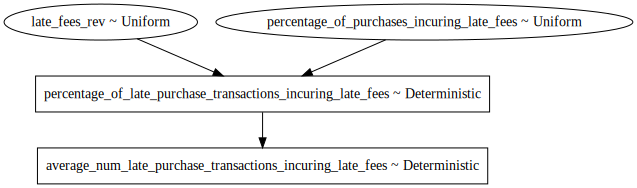

In [6]:
pm.model_to_graphviz(model)

Now we can draw samples from our model.

In [3]:
with model:
    samples = pm.sample_prior_predictive(samples=50_000, random_seed=0)

## Results

### Average late payments per purchase

We can now visualise the distribution of the number of late transactions per purchase, given that there are one or more late fees. Because we have considered the rounding, our model shows that sometimes there is less than one late payment per purchase. This is impossible in practice!

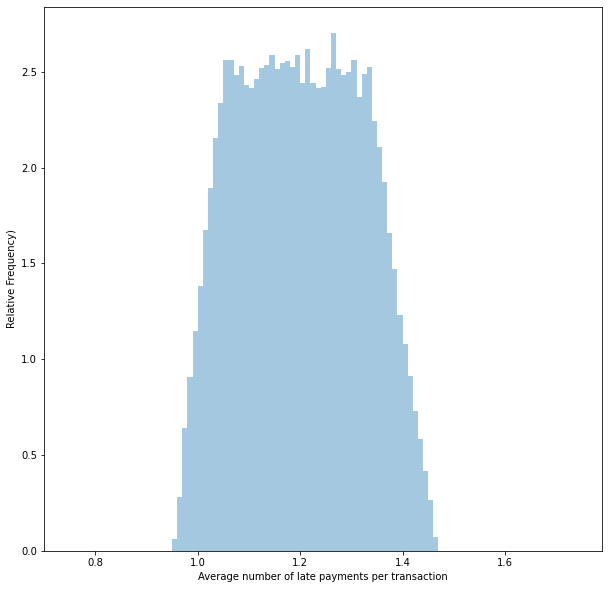

In [4]:
samples = samples['average_num_late_purchase_transactions_incuring_late_fees']

sns.distplot(samples,bins=np.arange(0.75,1.75,0.01),kde=False,norm_hist=True)
plt.xlabel('Average number of late payments per purchase')
plt.ylabel('Relative Frequency')
plt.show()

### Binomial assumption

Finally, we can make one last modelling assumption to help. 

Given that one of the four payments was late, we might assume that each of the three is equally and independently likely to be late. IE, we use the *Binomial* distribution to model late payments.

Binomial($n$,$p$), where $n$ is 3, and we want to find $p$.

Given the mean of this distribution is $n\times p$, we can find $p = \frac{(samples - 1)}{3}$.


In [ ]:
probability_of_late_payment_per_payment = 100 * (samples - 1) /3.0

Putting this all together, we can now find a distribution for $p$.

I'm also going to fit a *Beta* distribution to it so I can draw samples from it in the next post.

In [36]:
probability_of_late_payment_per_payment = probability_of_late_payment_per_payment[np.where(probability_of_late_payment_per_payment>0)]

a1, b1, loc1, scale1  = st.beta.fit(probability_of_late_payment_per_payment)
print('Alpha: {:0.4f}, Beta: {:0.4f}, Location: {:0.4f}, Scale: {:0.4f}'.format(a1, b1, loc1, scale1 ))

Alpha: 1.3447, Beta: 1.7199, Location: -0.0142, Scale: 15.5965


Let's also visualise the distribution and the fitted *Beta* distribution.

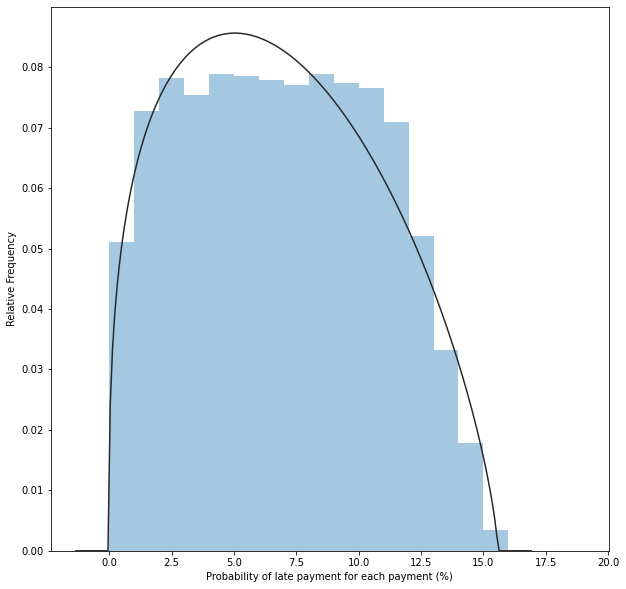

In [37]:
sns.distplot(probability_of_late_payment_per_payment,fit=st.beta, bins=np.arange(0,20),kde=False,norm_hist=True)
plt.xlabel('Probability of late payment for each payment (%)')
plt.ylabel('Relative Frequency')
plt.show()

In [23]:
pm.summary(probability_of_late_payment_per_payment)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 48482), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,6.898,3.844,0.051,12.912,0.018,0.012,47746.0,47746.0,47675.0,48623.0,NaN


## Conclusion

Based on what *Afterpay* has publicly released, we now have a more concrete perspective on how often people pay late.

Interestingly, while there is a ±10% chance of someone having at least one late payment on any given purchase, the probability of any subsequent individual payment being late is relatively low. It's at most ±13%, with the best estimate of 7%. 